In [13]:
import sys
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np

# import yfinance as yf
# from fredapi import Fred

import matplotlib.pyplot as plt

In [ ]:
%debug

In [ ]:
# %matplotlib widget


In [4]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error

In [5]:
os.environ['PYTHONPATH'] = r"D:\Pycharm_Projects\options_trading"

In [6]:
os.environ['PYTHONPATH']

'D:\\Pycharm_Projects\\options_trading'

In [7]:
import src.predict as P

In [8]:
plot_ratio = pd.read_csv(os.path.join(os.environ['PYTHONPATH'],'data','OVX_VIX_Ratio.csv'),index_col=0)
plot_ratio = plot_ratio.set_index('Date')
plot_ratio.index = pd.to_datetime(plot_ratio.index)

plot_ratio = plot_ratio.loc[~plot_ratio['Z_Score'].isna(),:]
plot_ratio.index = plot_ratio.index.map(lambda x: pd.to_datetime(x).date())
plot_ratio.head()

,OVX,VIX,Ratio,Rolling30,Diff,Mean,STD,Z_Score,Max_1y_Z_Score,Min_1y_Z_Score
Date,,,,,,,,,,
2008-05-09,37.430000,19.410000,1.928387,1.881357,0.047030,1.558837,0.278349,1.327652,NaN,NaN
2008-05-12,37.549999,17.790001,2.110736,1.900537,0.210199,1.557401,0.278086,1.989799,NaN,NaN
2008-05-13,38.110001,17.980000,2.119577,1.912812,0.206765,1.559623,0.279768,2.001492,NaN,NaN
2008-05-14,36.799999,17.660000,2.083805,1.925422,0.158383,1.561687,0.281140,1.857147,NaN,NaN
2008-05-15,38.770000,16.299999,2.378528,1.946154,0.432374,1.563372,0.284725,2.862958,NaN,NaN


In [9]:
look_back_lag = 15
y_var_name='Z_Score'


data = plot_ratio.loc[:,[y_var_name]]
for i in range(1,look_back_lag+1):
    data.loc[:,'Lag_'+str(i)] = data[[y_var_name]].shift(i)
data = data.dropna(axis=0,how='any')
data.tail(6).iloc[:,0:10]

,Z_Score,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9
Date,,,,,,,,,,
2025-06-17,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445,-0.170514,0.514586
2025-06-18,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445,-0.170514
2025-06-20,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445
2025-06-23,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085
2025-06-24,1.983490,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005
2025-06-25,1.381541,1.983490,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283


# Recursive strategy

In [10]:
import importlib
importlib.reload(P)

<module 'src.predict' from 'D:\\Pycharm_Projects\\options_trading\\src\\predict.py'>

In [11]:
recursive_results = {}
direct_rec_results = {}
horizon = 3

min_obs = 252*3
max_obs = 252*5

ind_start = 0
# while ind_start < data.shape[0]-max_obs-horizon:
#while ind_start < 10:

ind_end = ind_start+max_obs

last_date_index = data.index[ind_end]

x_train, y_train, x_predict, true_Y = P.prepare_data(
    full_data = data,
    data_ind_start = ind_start,
    data_ind_end = ind_end,
    horizon=horizon,
    look_back_lag=look_back_lag,
    y_var_name=y_var_name)

model = MultiOutputRegressor(XGBRegressor())
    
true_Y_recursive =  P.recursive_strategy(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_predict=x_predict,
    true_Y=true_Y,
    horizon = horizon, 
    look_back_lag = look_back_lag)

true_Y_DirRec = P.direct_recursive_strategy(    
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_predict=x_predict,
    true_Y=true_Y,
    horizon = horizon, 
    look_back_lag = look_back_lag)

recursive_results[last_date_index] = true_Y_recursive
direct_rec_results[last_date_index] = true_Y_DirRec
ind_start += 1

if ind_start%30==0:
    print(last_date_index)

> d:\pycharm_projects\options_trading\src\predict.py(48)direct_recursive_strategy()
     46     for i in range(1,horizon):
     47         import pdb
---> 48         pdb.set_trace()
     49         x_predict = np.concatenate((y_predict[0],x_predict[0][0:(look_back_lag-1)])).reshape(1,-1)
     50 

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> d:\pycharm_projects\options_trading\src\predict.py(48)direct_recursive_strategy()
     46     for i in range(1,horizon):
     47         import pdb
---> 48         pdb.set_trace()
     49         x_predict = np.concatenate((y_predict[0],x_predict[0][0:(look_back_lag-1)])).reshape(1,-1)
     50 

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [ ]:
1


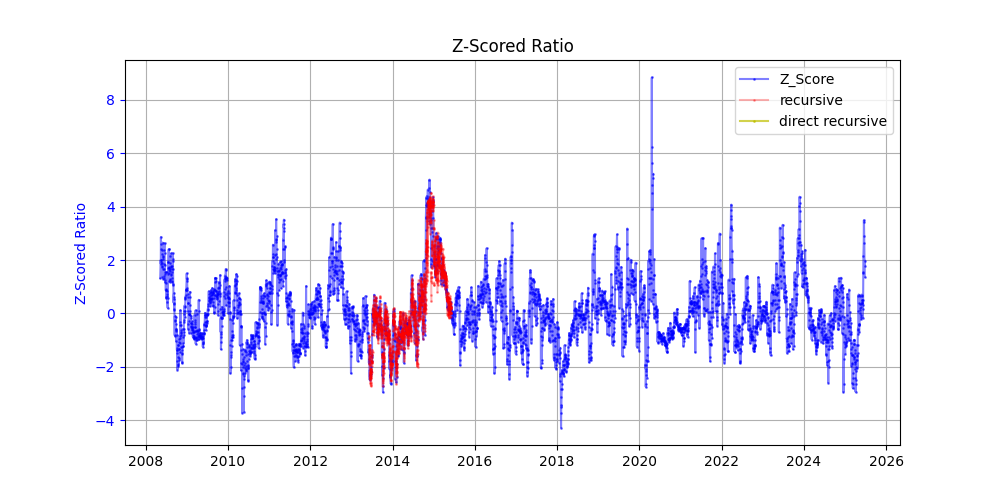

In [38]:
plt.ion()
fig_h, ax = plt.subplots(figsize=(10,5))

p1, = ax.plot(plot_ratio.index,plot_ratio[y_var_name],color='b',marker='.',ms=2,
              alpha=0.5,label=y_var_name)

for k,v in recursive_results.items():
    p2, = ax.plot(v.index,v.pred,'-',color='r',marker='.',ms=2,alpha=0.3,label='recursive')

# for k,v in direct_rec_results.items():
#     p3, = ax.plot(v.index,v.pred,'-',color='y',marker='.',ms=2,alpha=0.7,label='direct recursive')

ax.grid()
ax.set_ylabel('Z-Scored Ratio', color='b')
ax.tick_params('y', colors='b')
plt.legend(handles=[p1,p2,p3])

# ylim_vals = plt.ylim()
# plt.vlines(last_date_index,ylim_vals[0],ylim_vals[1],color='r')

# plt.xlim([datetime.date(2011,5,1), datetime.date(2013,7,1)])
#plt.xlim([datetime.date(2011,5,1), datetime.date(2011,7,1)])

plt.title("Z-Scored Ratio")
plt.show()


In [34]:
rmse_df = []

for k,v in direct_rec_results.items():
    rmse_df.append([k, v.iloc[0,0],v['pred'].max(),v['pred'].min(),
                    root_mean_squared_error(v[y_var_name],v.pred),
                    mean_squared_error(v[y_var_name],v.pred),
                    mean_absolute_error(v[y_var_name],v.pred)])
rmse_df = pd.DataFrame(rmse_df,columns=['Date','True','Pred_Max','Pred_Min','RMSE','MSE','MAE'])
rmse_df = rmse_df.set_index('Date')
rmse_df.tail()

,True,Pred_Max,Pred_Min,RMSE,MSE,MAE
Date,,,,,,
2015-05-28,0.090208,0.438310,0.425319,0.289539,0.083833,0.286039
2015-05-29,0.181818,0.027929,0.017650,0.255885,0.065477,0.229535
2015-06-01,0.162155,0.196859,0.152384,0.142603,0.020336,0.105634
2015-06-02,0.416566,0.053876,0.025637,0.268188,0.071925,0.236071
2015-06-03,0.267517,0.264997,0.245690,0.309662,0.095890,0.253546


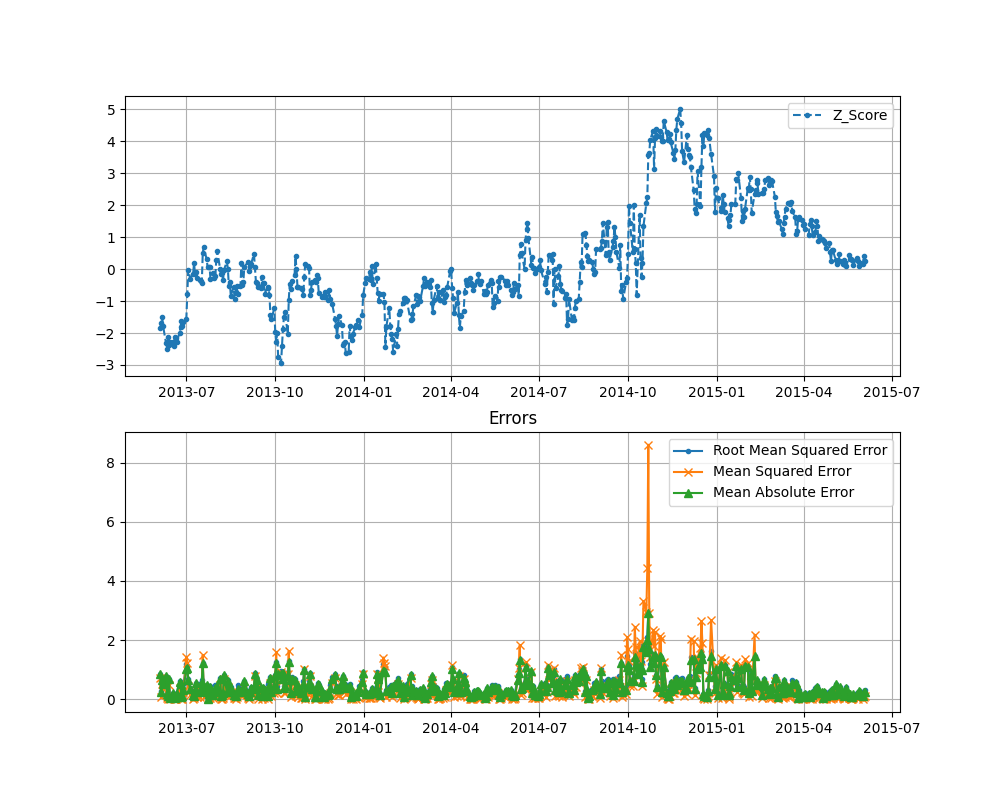

In [35]:
plt.figure(figsize=(10,8))

ax = plt.subplot(2,1,1)

ax.plot(rmse_df.index,rmse_df['True'],label=y_var_name,marker='.',ls='--')

# ax.fill_between(rmse_df.index,rmse_df['Pred_Max'], rmse_df['Pred_Min'],
#                 facecolor='grey',label='Prediction',hatch='x',ec='white',alpha=0.5)
                
# ax.plot(rmse_df.index,rmse_df['Pred_Max'],label='pred Max',marker='.',ls=':',color='r')
# ax.plot(rmse_df.index,rmse_df['Pred_Min'],label='pred min',marker='.',ls=':',color='r')
plt.legend()
plt.grid()

ax2 = plt.subplot(2,1,2)
ax2.plot(rmse_df.index,rmse_df.RMSE,label='Root Mean Squared Error',marker='.')
ax2.plot(rmse_df.index,rmse_df.MSE,label='Mean Squared Error',marker='x')
ax2.plot(rmse_df.index,rmse_df.MAE,label='Mean Absolute Error',marker='^')
plt.title('Errors')

plt.legend()
plt.grid()
plt.show()

In [36]:
rmse_df.loc[rmse_df.MSE == rmse_df.MSE.max(),:]

,True,Pred_Max,Pred_Min,RMSE,MSE,MAE
Date,,,,,,
2014-10-22,3.569394,0.828827,0.813929,2.932813,8.601395,2.92539


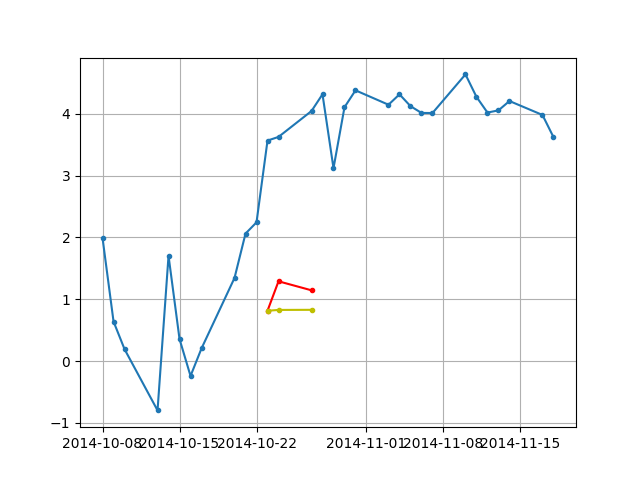

In [37]:
selected_date = datetime.date(2014,10,22)


r1 = recursive_results[selected_date]
r2 = direct_rec_results[selected_date]
ref_ind = plot_ratio.index.to_list().index(selected_date)
ref_df = plot_ratio.iloc[ref_ind-10:ref_ind+20,:]

plt.figure()
plt.plot(ref_df.index,ref_df[y_var_name],'-',marker='.')

plt.plot(r1.index,r1.pred,label='Recursive',color='r',marker='.')
plt.plot(r2.index,r2.pred,label='Direct Recursive',color='y',marker='.')


plt.grid()

plt.show()

